<a href="https://colab.research.google.com/github/erikfrey/aloha/blob/main/aloha_render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aloha Bring To Target

In [16]:
%%bash
pip install brax
rm -rf mujoco_menagerie
git clone https://github.com/google-deepmind/mujoco_menagerie.git
cd mujoco_menagerie/aloha/
patch -p0 < mjx_scene.patch
patch -p0 < mjx_aloha.patch
patch -p0 < mjx_filtered_cartesian_actuators.patch
mv scene.xml mjx_scene.xml
mv aloha.xml mjx_aloha.xml
mv filtered_cartesian_actuators.xml mjx_filtered_cartesian_actuators.xml
cat >mjx_single_cube.xml <<EOF
<mujoco model="aloha with a single cube">
  <size nuserdata="1"/>
  <include file="mjx_scene.xml"/>
  <worldbody>
    <body name="box" pos="0.35 0.2 0.025">
      <freejoint/>
      <geom name="box" type="box" size="0.015 0.02 0.03" condim="3"
        friction="2.5 .03 .003" rgba="0 1 0 1" contype="1" conaffinity="1"/>
    </body>
  </worldbody>
  <keyframe>
    <key name="home" qpos="
      0 -0.96 1.16 0 -0.3 0 0.0084 0.0084
      0 -0.96 1.16 0 -0.3 0 0.0084 0.0084
      0.35 0.2 0.025 1 0 0 0"
      act= "-0.1 0 0 0 0 0 0.03 0.1 0 0 0 0 0 0.03"
      ctrl="-0.1 0 0 0 0 0 0.03 0.1 0 0 0 0 0 0.03"
    />
  </keyframe>
</mujoco>
EOF

patching file scene.xml
Hunk #1 succeeded at 1 with fuzz 1.
patching file aloha.xml
patching file filtered_cartesian_actuators.xml


Cloning into 'mujoco_menagerie'...
Updating files: 100% (961/961), done.


In [14]:
import functools
import os
from datetime import datetime
from typing import Any

from IPython.display import HTML, clear_output
from etils import epath

import jax
import jax.numpy as jp
import matplotlib.pyplot as plt
import mujoco

from brax import base
from brax.envs.base import PipelineEnv
from brax.envs.base import State
from brax.io import html
from brax.io import mjcf
from brax.training.agents.ppo import train as ppo

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

In [17]:
# @title Setup ALOHA env

def _load_sys(path: str) -> base.System:
  path = epath.Path(path)
  xml = path.read_text()
  assets = {}
  for f in path.parent.glob('*.xml'):
    assets[f.name] = f.read_bytes()
    for f in (path.parent / 'assets').glob('*'):
      assets[f.name] = f.read_bytes()
  model = mujoco.MjModel.from_xml_string(xml, assets)

  # current overrides to get this working:
  # TODO(erikfrey): tune this.  big slowdown from iterations.
  model.opt.timestep = 0.005
  model.numeric_data[0] = 10            # raises max_contacts to 10
  model.actuator_dynprm[0:6, 0] = 0.5   # allows actuators to move faster
  model.actuator_dynprm[7:13, 0] = 0.5  # ... leave gripper dynprm as is
  model.opt.iterations = 10             # improves solver stability
  model.opt.ls_iterations = 10          # improves solver stability

  return mjcf.load_model(model)


class AlohaBringToTarget(PipelineEnv):
  """Environment for training aloha to bring an object to target."""

  def __init__(self, **kwargs):
    sys = _load_sys('/content/mujoco_menagerie/aloha/mjx_single_cube.xml')
    kwargs['backend'] = 'mjx'
    super().__init__(sys, **kwargs)

    # For rewards
    self._left_gripper_site_index = 3
    self._right_gripper_site_index = 6
    self._box_body_index = sys.mj_model.nbody - 1
    self._box_q_index = 16

    # Init qpos
    self._init_q = jp.array([0.0748744, -0.0298622, 0.869616, 0.0954888,
                             -0.887428, -0.0637624, 0.002, 0.002, -0.0772142,
                             -0.03, 0.869422, -0.100858, -0.887171, 0.0673553,
                             0.002, 0.002, 0, 0, 0.0255684, 1, 0, 0, 0])

    # Action limits and dimension
    self.action_dim = sys.mj_model.actuator_ctrlrange.shape[0]
    self.lowers = sys.mj_model.actuator_ctrlrange[:, 0]
    self.uppers = sys.mj_model.actuator_ctrlrange[:, 1]

  def reset(self, rng: jax.Array) -> State:
    rng, rng_target, rng_box = jax.random.split(rng, 3)

    target_xy = jax.random.uniform(rng_target, (2,), minval=-0.15, maxval=0.15)
    target_z = jax.random.uniform(rng_target, (1,), minval=0.1, maxval=0.4)
    target_pos = jp.array([0, 0, 0.3])

    box_xy = jax.random.uniform(rng_box, (2,), minval=-0.15, maxval=0.15)
    box_pos = jp.append(box_xy, jp.array(0.02))

    init_q = self._init_q.at[self._box_q_index:self._box_q_index + 3].set(box_pos)
    pipeline_state = self.pipeline_init(init_q, jp.zeros(self.sys.nv))

    info = {'rng': rng, 'target_pos': target_pos}
    obs = self._get_obs(pipeline_state, info)
    reward, done = jp.zeros(2)
    metrics = {'gripper_reward': jp.array(0.0),
               'box_reward': jp.array(0.0),
               'out_of_bounds': jp.array(0.0)}
    state = State(pipeline_state, obs, reward, done, metrics, info)

    return state

  def step(self, state: State, action: jax.Array) -> State:
    action = jp.clip(action, -1.0, 1.0)
    action = (action + 1) * 0.5  # move from [-1, 1] => [0, 1]
    ctrl = action * (self.uppers - self.lowers) + self.lowers

    data = self.pipeline_step(state.pipeline_state, ctrl)

    target_pos = state.info['target_pos']
    box_pos = data.xpos[self._box_body_index]

    box_reward = jp.exp(-10 * jp.linalg.norm(target_pos - box_pos))

    left_gripper_pos = data.site_xpos[self._left_gripper_site_index]
    right_gripper_pos = data.site_xpos[self._right_gripper_site_index]
    left_reward = jp.exp(-10 * jp.linalg.norm(box_pos - left_gripper_pos))
    right_reward = jp.exp(-10 * jp.linalg.norm(box_pos - right_gripper_pos))
    gripper_reward = jp.maximum(left_reward, right_reward)

    gripper_open = data.act[6] + data.act[13]

    out_of_bounds = jp.any(jp.abs(box_pos) > 1.0)
    reward = 20 * box_reward + gripper_reward + gripper_open
    done = out_of_bounds.astype(float)
    state.metrics.update(
        gripper_reward=gripper_reward,
        box_reward=box_reward,
        out_of_bounds=out_of_bounds.astype(float))
    obs = self._get_obs(data, state.info)
    state = State(data, obs, reward, done, state.metrics, state.info)

    return state

  def _get_obs(self, data: base.State, info: dict[str, Any]) -> jax.Array:
    # gripper and box positions
    left_gripper_pos = data.site_xpos[self._left_gripper_site_index]
    left_gripper_mat = data.site_xmat[self._left_gripper_site_index].ravel()
    right_gripper_pos = data.site_xpos[self._right_gripper_site_index]
    right_gripper_mat = data.site_xmat[self._right_gripper_site_index].ravel()
    box_pos = data.xpos[self._box_body_index]
    box_mat = data.xmat[self._box_body_index].ravel()
    obs = jp.concatenate([
        data.act,
        left_gripper_pos,
        right_gripper_pos,
        left_gripper_mat,
        right_gripper_mat,
        box_pos,
        box_mat,
        info['target_pos'],
    ])

    return obs

env = AlohaBringToTarget()
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)

/usr/local/lib/python3.10/dist-packages/brax/io/mjcf.py:344: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  link = jax.tree_map(lambda x: x[1:].copy(), link)


# Train Aloha Bring To Target


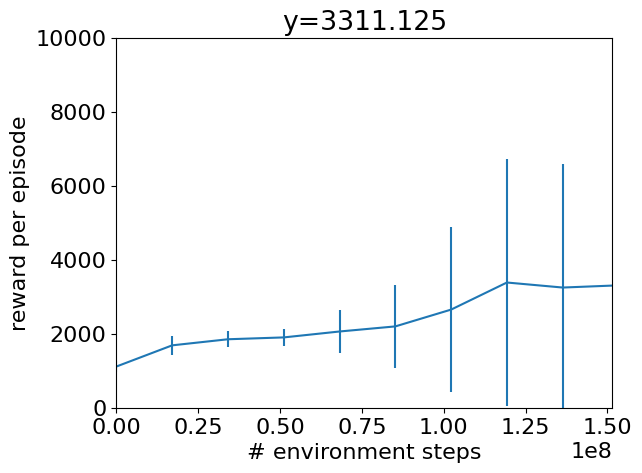

time to jit: 0:01:21.374229
time to train: 0:31:36.927982


In [18]:
train_fn = functools.partial(
    ppo.train, num_timesteps=150_000_000, num_evals=10, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=2,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=1024,
    batch_size=1024, seed=0)

xdata, ydata, ydataerr = [], [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  clear_output(wait=True)
  plt.rcParams.update({'font.size': 16})
  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.01])
  plt.ylim([0, 10000])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={ydata[-1]:.3f}')
  plt.errorbar(xdata, ydata, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)
jit_inference_fn = jax.jit(make_inference_fn(params))

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [19]:
#@title Visualize

rollout = []
rng = jax.random.PRNGKey(seed=2)
state = jit_env_reset(rng=rng)

for i in range(1000):
  act_rng, rng = jax.random.split(rng)
  rollout.append(state.pipeline_state)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

  if state.done:
    print('Done: ', i)
    break

In [21]:
HTML(html.render(env.sys, rollout))

In [55]:
# example raycast render
import numpy as np
from mujoco import mjx

width = 128
height = 128
fovy = np.deg2rad(58)
f = 0.1
cam_id = 1

# dimensions of image plane
h_ip = np.tan(fovy/2) * 2 * f
w_ip = h_ip * (width / height)
delta = w_ip / (2 * width)
xs = np.linspace(-w_ip/2 + delta, w_ip/2 - delta, width)
ys = np.flip(np.linspace(-h_ip/2 + delta, h_ip/2 - delta, height))
xs, ys = np.tile(xs, height), np.repeat(ys, width)

cam_x = jp.array(xs)
cam_y = jp.array(ys)
cam_vec = jax.vmap(lambda x, y, m=state.pipeline_state.cam_xmat[cam_id]: m @ jp.array([x, y, -f]))(cam_x, cam_y)
cam_vec = jax.vmap(lambda x: x / jp.linalg.norm(x))(cam_vec)
cam_pos = state.pipeline_state.cam_xpos[cam_id]

def render():
  geomgroup = [True, True, True, False, False, False]
  def fn(_, vec):
    dist, _ = mjx.ray(env.sys, state.pipeline_state, cam_pos, vec, geomgroup)
    return None, dist
  _, dist = jax.lax.scan(fn, None, cam_vec)
  return dist

depth = jax.jit(render)()

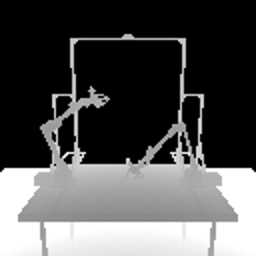

In [58]:
from PIL import Image

depth = np.array(depth).reshape(128, 128)

Image.fromarray(depth * 100, "F").convert("RGB").resize((256, 256))